In [70]:
from pathlib import Path
from dataclasses import dataclass
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from typing import Any
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
%load_ext autoreload
%autoreload 2


@dataclass
class Config:
    REPO_ROOT: Path = Path("../../")
    data_dir: Path = REPO_ROOT / "data"


config = Config()

sys.path.append(str(config.REPO_ROOT))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
from python.src.preprocess import (
    preprocess_bike_data,
)

df_bike = pd.read_csv(config.data_dir / "bike+sharing+dataset" / "day.csv")
df_bike_processed = preprocess_bike_data(df=df_bike)
assert df_bike.shape[0] == df_bike_processed.shape[0]

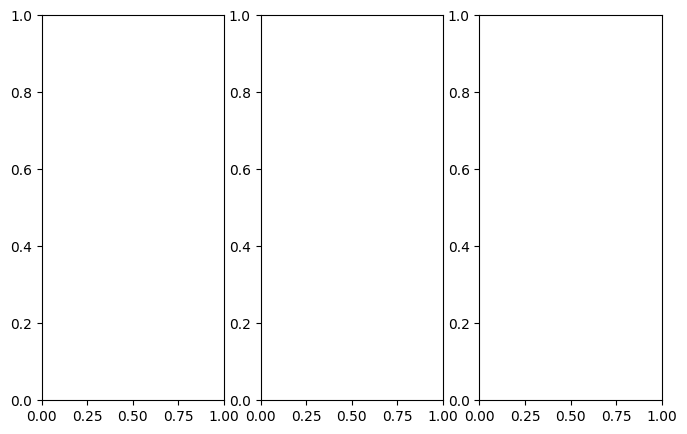

In [3]:
from python.src.utils import PartialDependence

features = ["temp", "hum", "windspeed"]
X = df_bike_processed[features]
y = df_bike_processed["cnt"]
# Train a RandomForestRegressor model
model = RandomForestRegressor(random_state=0)  # random_state for reproducibility
model.fit(X, y)
pdp = PartialDependence(model, X, ["temp", "hum", "windspeed"], pred_type="regression")

fig, axes = plt.subplots(1, 3, figsize=(8, 5))

# Set y-axis limits directly
y_min = -500
y_max = 7000

# Create the PDP plots
# for i, (feature, ax) in enumerate(zip(["temp", "hum", "windspeed"], axes.ravel())):
df_pd = pdp.partial_dependence(["temp", "hum"], n_grid=15)

In [15]:
df_pd = pdp.partial_dependence(["temp", "hum"], n_grid=15)

In [16]:
df_temp = pdp.partial_dependence(["temp"], n_grid=15)
df_temp = df_temp.rename(columns={"avg_pred": "avg_pred_temp"})

In [17]:
df_hum = pdp.partial_dependence(["hum"], n_grid=15)
df_hum = df_hum.rename(columns={"avg_pred": "avg_pred_hum"})

In [18]:
df_pd2 = pd.merge(df_pd, df_temp, on="temp", how="left")
df_pd3 = pd.merge(df_pd2, df_hum, on="hum", how="left")

In [23]:
df_pd3["H_stats_numerator"] = (
    df_pd3["avg_pred"] - df_pd3["avg_pred_temp"] - df_pd3["avg_pred_hum"]
) ** 2
df_pd3["H_stats_denominator"] = df_pd3["avg_pred"] ** 2

In [24]:
df_pd3["H_stats_numerator"].sum() / df_pd3["H_stats_denominator"].sum()

np.float64(1.0712995203481508)

In [72]:
df_bike_processed["holiday"] = df_bike_processed["holiday"].map(
    {"HOLIDAY": 1, "NO HOLIDAY": 0}
)
df_bike_processed["season"] = df_bike_processed["season"].map(
    {
        "WINTER": 1,
        "SPRING": 2,
        "SUMMER": 3,
        "FALL": 4,
    }
)
df_bike_processed["workingday"] = df_bike_processed["workingday"].map(
    {"WORKING DAY": 1, "NO WORKING DAY": 0}
)
df_bike_processed["mnth"] = df_bike_processed["mnth"].map(
    {
        "JAN": 1,
        "FEB": 2,
        "MAR": 3,
        "APR": 4,
        "MAY": 5,
        "JUN": 6,
        "JUL": 7,
        "AUG": 8,
        "SEP": 9,
        "OCT": 10,
        "NOV": 11,
        "DEC": 12,
    }
)
df_bike_processed["weekday"] = df_bike_processed["weekday"].map(
    {
        "SUN": 1,
        "MON": 2,
        "TUE": 3,
        "WED": 4,
        "THU": 5,
        "FRI": 6,
        "SAT": 7,
    }
)
df_bike_processed["weathersit"] = df_bike_processed["weathersit"].map(
    {"MISTY": 1, "GOOD": 2, "RAIN/SNOW/STORM": 3}
)

# 必要な特徴量を選択
# features_of_interest = [
#     "days_since_2011",
#     "temp",
#     "season",
#     "windspeed",
#     "hum",
#     "yr",
#     "mnth",
#     "holiday",
#     "weekday",
#     "workingday",
#     "weathersit",
# ]  # Rのコードに合わせる
# enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# # カテゴリ変数と数値変数を分離
# categorical_features = ["season", "mnth", "weekday", "weathersit"]
# numerical_features = [
#     "days_since_2011",
#     "temp",
#     "windspeed",
#     "hum",
#     "holiday",
#     "workingday",
# ]
# OneHotEncoderを適用
# encoded_features = enc.fit_transform(df_bike_processed[categorical_features])
# encoded_df = pd.DataFrame(
#     encoded_features, columns=enc.get_feature_names_out(categorical_features)
# )

# # 数値変数と結合
# X = pd.concat([df_bike_processed[numerical_features], encoded_df], axis=1)
X = df_bike_processed.drop(columns="cnt")
y = df_bike_processed["cnt"]

In [73]:
from sklearn.svm import SVR

In [82]:
df_bike_processed_sampled = df_bike_processed.sample(n=300, random_state=42)
X_sampled = df_bike_processed_sampled.drop(columns="cnt")
y_sampled = df_bike_processed_sampled["cnt"]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
X_sampled_scaled = pd.DataFrame(
    scaler.fit_transform(X_sampled), columns=X_sampled.columns, index=X_sampled.index
)

svr = SVR(kernel="rbf", C=1.0, epsilon=0.2)  # Adjust C and epsilon as needed
svr.fit(X, y)

SVR(epsilon=0.2)

In [79]:
from tqdm import tqdm

In [77]:
X_scaled.shape

(731, 11)

In [86]:
h_stat_dict = {}
features = list(X.columns)
pdp = PartialDependence(svr, X_sampled_scaled, features, pred_type="regression")

for col in tqdm(features):
    rest_cols = list(filter(lambda x: x != col, features))
    h_stat_dict[col] = {}
    for rest_col in rest_cols:
        df_pd_ij = pdp.partial_dependence([col, rest_col], n_grid=15)
        df_pd_ij = df_pd_ij.rename(columns={"avg_pred": "avg_pred_ij"})
        df_pd_i = pdp.partial_dependence([col], n_grid=15)
        df_pd_i = df_pd_i.rename(columns={"avg_pred": "avg_pred_i"})
        df_pd_j = pdp.partial_dependence([rest_col], n_grid=15)
        df_pd_j = df_pd_j.rename(columns={"avg_pred": "avg_pred_j"})
        df_pd_ij_merged = pd.merge(df_pd_ij, df_pd_i, on=col, how="left")
        df_pd_ij_merged = pd.merge(df_pd_ij_merged, df_pd_j, on=rest_col, how="left")
        df_pd_ij_merged["H_stats_numerator"] = (
            df_pd_ij_merged["avg_pred_ij"]
            - df_pd_ij_merged["avg_pred_i"]
            - df_pd_ij_merged["avg_pred_j"]
        ) ** 2
        df_pd_ij_merged["H_stats_denominator"] = df_pd_ij_merged["avg_pred_ij"] ** 2
        hstats = (
            df_pd_ij_merged["H_stats_numerator"].sum()
            / df_pd_ij_merged["H_stats_denominator"].sum()
        )
        h_stat_dict[col][rest_col] = hstats

100%|██████████| 11/11 [05:40<00:00, 30.99s/it]


In [87]:
h_stat_dict

{'season': {'yr': np.float64(1.0000001447851132),
  'mnth': np.float64(0.9999999984257701),
  'holiday': np.float64(0.9999999949153453),
  'weekday': np.float64(0.9999999996153656),
  'workingday': np.float64(0.9999999998559629),
  'weathersit': np.float64(0.9999999985026774),
  'temp': np.float64(1.0000000085993368),
  'hum': np.float64(0.9999998622728575),
  'windspeed': np.float64(1.000000066661044),
  'days_since_2011': np.float64(0.9999995960375548)},
 'yr': {'season': np.float64(1.0000001447851137),
  'mnth': np.float64(1.0000001440869926),
  'holiday': np.float64(1.0000001405739163),
  'weekday': np.float64(1.0000001452743807),
  'workingday': np.float64(1.0000001455149727),
  'weathersit': np.float64(1.0000001441618478),
  'temp': np.float64(1.0000001542207264),
  'hum': np.float64(1.0000000078669302),
  'windspeed': np.float64(1.0000002123309475),
  'days_since_2011': np.float64(0.9999997313777141)},
 'mnth': {'season': np.float64(0.9999999984257707),
  'yr': np.float64(1.0000